In [47]:
pip install opencv-python numpy matplotlib


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [49]:
# load images
query_img_color = cv2.imread('img1.png')
train_img_color = cv2.imread('img2.png')

# check if images loaded successfully
if query_img_color is None or train_img_color is None:
    print("Error: Could not load images")
    exit()

# convert to grayscale
query_img = cv2.cvtColor(query_img_color, cv2.COLOR_BGR2GRAY)
train_img = cv2.cvtColor(train_img_color, cv2.COLOR_BGR2GRAY)

# display image dimensions
print(f"Query image shape: {query_img.shape}")
print(f"Train image shape: {train_img.shape}")


Query image shape: (300, 400)
Train image shape: (298, 400)


In [50]:
orb = cv2.ORB_create(
    nfeatures=2000,
    scaleFactor=1.2,
    nlevels=8,
    edgeThreshold=31,
    firstLevel=0,
    WTA_K=2,
    scoreType=cv2.ORB_HARRIS_SCORE,
    patchSize=31,
    fastThreshold=20
)


In [51]:
# detect keypoints and compute descriptors for both images
kp_query, des_query = orb.detectAndCompute(query_img, None)
kp_train, des_train = orb.detectAndCompute(train_img, None)

# print statistics
print(f"Query image: {len(kp_query)} keypoints detected")
print(f"Train image: {len(kp_train)} keypoints detected")

# examine a keypoint structure
if kp_query:
    kp = kp_query[0]
    print(f"\nKeypoint attributes:")
    print(f"  Position: ({kp.pt[0]:.2f}, {kp.pt[1]:.2f})")
    print(f"  Size: {kp.size}")
    print(f"  Angle: {kp.angle}°")
    print(f"  Response: {kp.response}")

# check descriptor properties
print(f"\nDescriptor properties:")
print(f"  Shape: {des_query.shape}")
print(f"  Data type: {des_query.dtype}")
print(f"  Each descriptor: 32 bytes (256 bits)")


Query image: 1501 keypoints detected
Train image: 1521 keypoints detected

Keypoint attributes:
  Position: (181.00, 31.00)
  Size: 31.0
  Angle: 293.5655822753906°
  Response: 3.290473614470102e-05

Descriptor properties:
  Shape: (1501, 32)
  Data type: uint8
  Each descriptor: 32 bytes (256 bits)


In [52]:
# Brute-Force Matcher with cross-check
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# FLANN-based Matcher
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=12, key_size=20, multi_probe_level=2)
search_params = dict(checks=50)
# flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)


In [55]:
# find matching time
import time
import cv2

# create BFMatcher for ORB
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# time the detecting and matching
start = time.time()
start_detection = time.time()
kp_query, des_query = orb.detectAndCompute(query_img, None)
kp_train, des_train = orb.detectAndCompute(train_img, None)

detection_time = time.time() - start_detection

print(f"Detected {len(kp_query)} keypoints in query image")
print(f"Detected {len(kp_train)} keypoints in train image")
print(f"Detection + Description time: {detection_time:.4f} seconds")

matches = bf.match(des_query, des_train)
matching_time = time.time() - start
print(f"Matching time: {matching_time:.4f} seconds")
print(f"Number of matches: {len(matches)}")
start = time.time()
matches = bf.match(des_query, des_train)
matching_time = time.time() - start

# total time
total_time = detection_time + matching_time
print(f"Total pipeline time: {total_time:.4f} seconds")

Detected 1501 keypoints in query image
Detected 1521 keypoints in train image
Detection + Description time: 0.0190 seconds
Matching time: 0.0963 seconds
Number of matches: 433
Total pipeline time: 0.0954 seconds


In [56]:
# simple matching with cross-check
matches = bf_matcher.match(des_query, des_train)

# apply sorting
matches = sorted(matches, key=lambda x: x.distance)

# print match statistics
print(f"Total matches found: {len(matches)}")
if matches:
    distances = [m.distance for m in matches]
    print(f"  Best match distance: {min(distances)}")
    print(f"  Worst match distance: {max(distances)}")
    print(f"  Average distance: {np.mean(distances):.2f}")
    print(f"  Std deviation: {np.std(distances):.2f}")

# inspect first few matches
print("\nFirst 5 matches:")
for i, match in enumerate(matches[:5]):
    print(f"  Match {i}: query_idx={match.queryIdx}, train_idx={match.trainIdx}, distance={match.distance}")


Total matches found: 433
  Best match distance: 5.0
  Worst match distance: 80.0
  Average distance: 51.70
  Std deviation: 14.96

First 5 matches:
  Match 0: query_idx=534, train_idx=713, distance=5.0
  Match 1: query_idx=537, train_idx=706, distance=6.0
  Match 2: query_idx=267, train_idx=269, distance=7.0
  Match 3: query_idx=169, train_idx=284, distance=11.0
  Match 4: query_idx=723, train_idx=692, distance=11.0


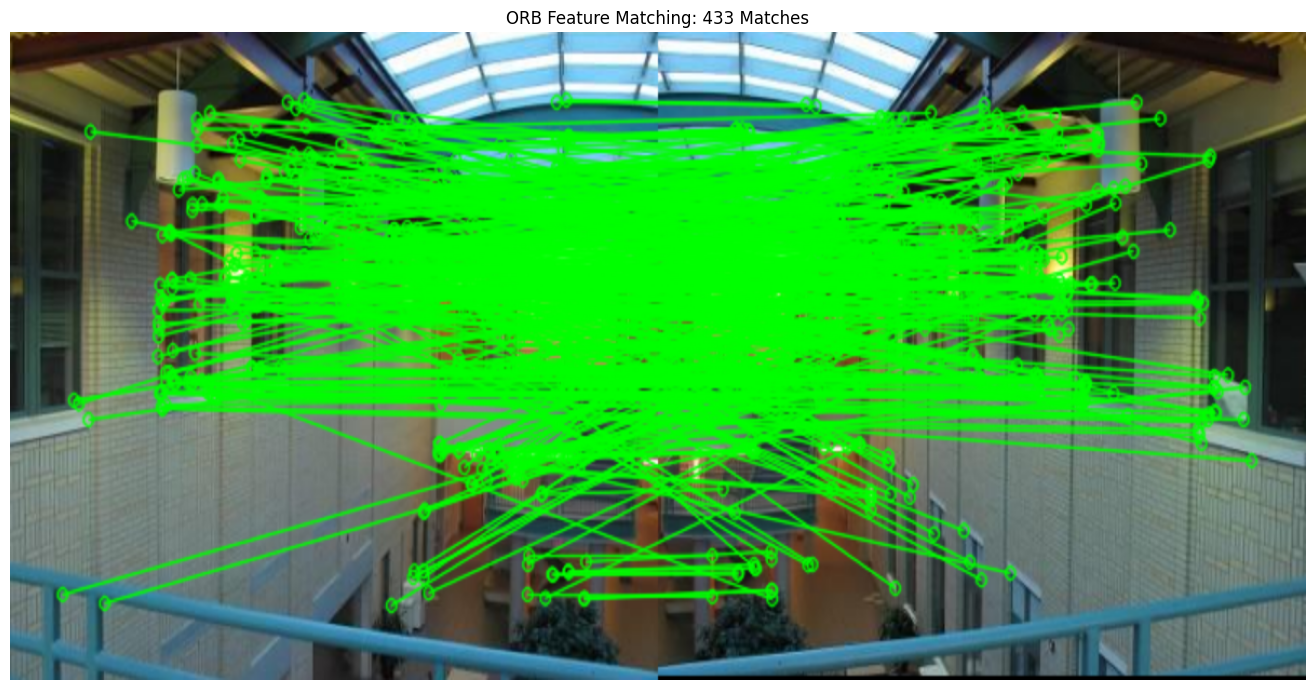

In [57]:
# draw matches
num_matches_to_draw = min(1000, len(matches))
result_img = cv2.drawMatches(
    query_img_color,              # first image (color)
    kp_query,                     # keypoints from first image
    train_img_color,              # second image (color)
    kp_train,                     # keypoints from second image
    matches[:num_matches_to_draw],  # matches to draw
    None,
    matchColor=(0, 255, 0),       # green for matches
    singlePointColor=(255, 0, 0), # red for unmatched points
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

# resize for better visibility
result_img = cv2.resize(result_img, (1200, 600))

# display using Matplotlib
plt.figure(figsize=(14, 7))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.title(f'ORB Feature Matching: {num_matches_to_draw} Matches')
plt.axis('off')
plt.tight_layout()
plt.show()

In [58]:
# sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)

# keep only good matches
good_matches = []
for match in matches:
    if match.distance < 50:  # threshold for ORB
        good_matches.append(match)

print(f"Found {len(good_matches)} good matches")


Found 143 good matches


Source points: (143, 1, 2), Dest points: (143, 1, 2)
Total matches for homography: 143
Homography matrix:
[[ 1.69009818e+00  3.99970188e-02 -4.99557848e+02]
 [ 2.28901123e-01  1.60508726e+00 -8.42865436e+01]
 [ 1.72216377e-03  2.79992315e-05  1.00000000e+00]]
Inlier count: 68 / 143 (47.6%)
RANSAC inliers: 68


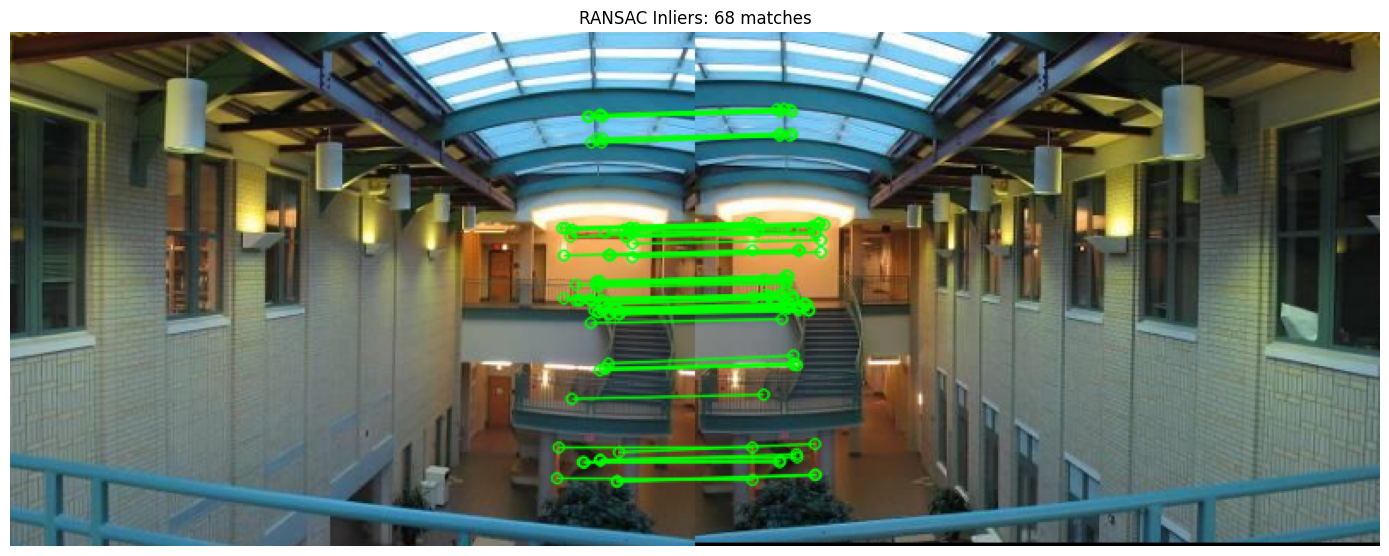

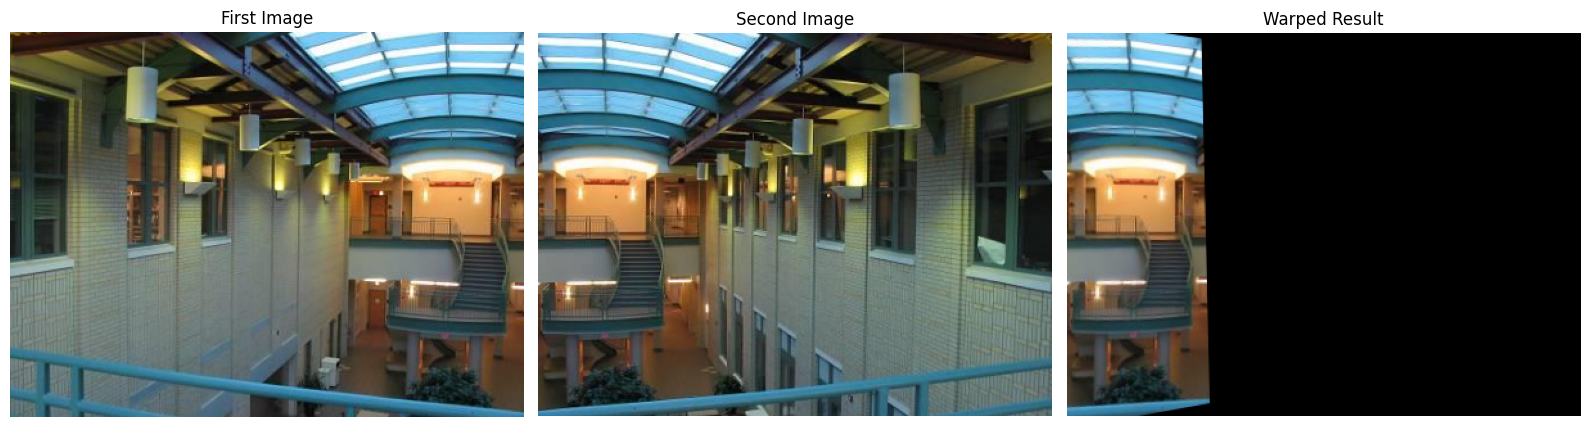

In [59]:
# extract corresponding keypoint coordinates
src_pts = np.float32([kp_query[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_train[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

print(f"Source points: {src_pts.shape}, Dest points: {dst_pts.shape}")
print(f"Total matches for homography: {len(good_matches)}")

# calculate homography matrix
H = None
mask = None
if len(good_matches) >= 4:
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 8.0)  # Relaxed threshold
    print(f"Homography matrix:\n{H}")
    print(f"Inlier count: {np.sum(mask)} / {len(good_matches)} ({np.sum(mask)/len(good_matches)*100:.1f}%)")
else:
    print(f"ERROR: Only {len(good_matches)} matches")

# show the image
if H is not None and mask is not None:
    inlier_matches = [m for i, m in enumerate(good_matches) if mask[i]]
    print(f"RANSAC inliers: {len(inlier_matches)}")

    inlier_img = cv2.drawMatches(
        query_img_color, kp_query, train_img_color, kp_train,
        inlier_matches[:100], None,
        matchColor=(0, 255, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(14, 7))
    plt.imshow(cv2.cvtColor(inlier_img, cv2.COLOR_BGR2RGB))
    plt.title(f'RANSAC Inliers: {len(inlier_matches)} matches')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# warp the image
if H is not None:
    h, w = train_img.shape
    query_warped = cv2.warpPerspective(query_img_color, H, (w*1, h*1))  # Larger canvas

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(query_img_color, cv2.COLOR_BGR2RGB))
    plt.title('First Image'); plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(train_img_color, cv2.COLOR_BGR2RGB))
    plt.title('Second Image'); plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(query_warped, cv2.COLOR_BGR2RGB))
    plt.title('Warped Result'); plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Cannot warp: No valid homography")


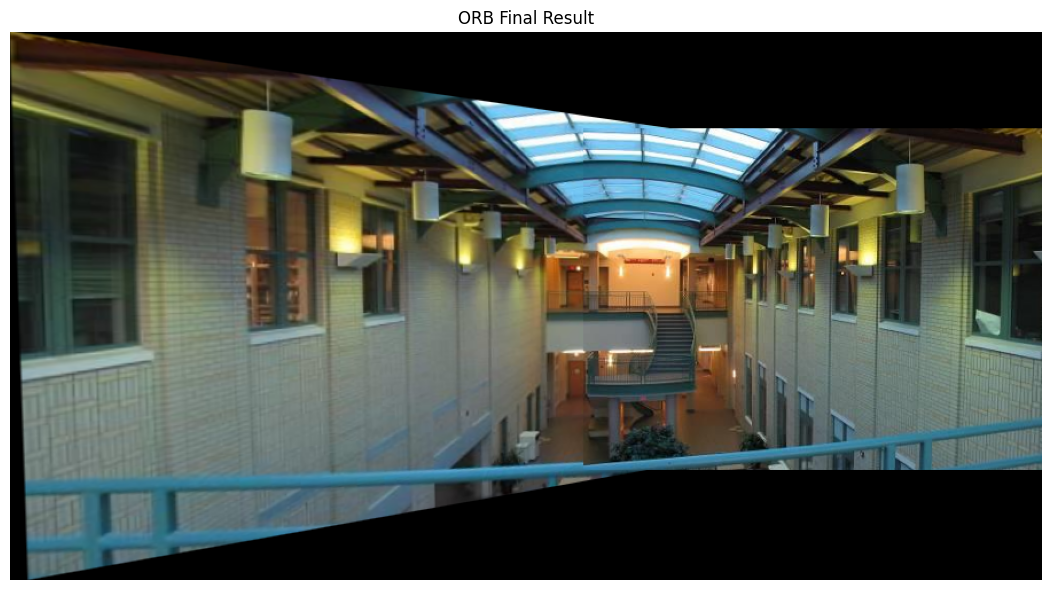

In [60]:
# final part for matching
if H is not None:
    h1, w1 = query_img_color.shape[:2]
    h2, w2 = train_img_color.shape[:2]

    # transform the 4 corners of the left image
    corners_q = np.float32([[0, 0],
                            [w1, 0],
                            [w1, h1],
                            [0, h1]]).reshape(-1, 1, 2)
    corners_q_warped = cv2.perspectiveTransform(corners_q, H)

    # combine with corners of the right image to find global bounds
    corners_t = np.float32([[0, 0],
                            [w2, 0],
                            [w2, h2],
                            [0, h2]]).reshape(-1, 1, 2)

    all_corners = np.vstack((corners_q_warped, corners_t))
    [xmin, ymin] = np.int32(all_corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(all_corners.max(axis=0).ravel() + 0.5)

    pano_w = xmax - xmin
    pano_h = ymax - ymin

    # translation to make all coords positive
    T = np.array([[1, 0, -xmin],
                  [0, 1, -ymin],
                  [0, 0, 1]], dtype=np.float32)

    # warp left image into panorama
    panorama = cv2.warpPerspective(query_img_color, T @ H, (pano_w, pano_h))

    # paste right image into panorama
    panorama[-ymin:h2 - ymin, -xmin:w2 - xmin] = train_img_color

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title('ORB Final Result')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
